In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

import torchvision.datasets as datasets
from pathlib import Path

from torchview import draw_graph

import constants
import dataset
import util
import json
import pandas as pd
import models 
from models import VQANet
import matplotlib.pyplot as plt
import numpy as np
import time

from transformers import AutoTokenizer

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():      
    device = 'mps'                         
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)




using device: mps


In [2]:

%load_ext autoreload
%autoreload 2

In [3]:

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [4]:
# with open(constants.CAPTION_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["annotations"][0])

# with open(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["questions"][0])

# with open(constants.VQA_OPEN_ENDED_ANSWER_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["annotations"][0])
    
# with open(constants.CAPTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_QUESTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_ANSWER_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

#dataset.load(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, ['image_id', 'id', 'caption'])

In [5]:
train = dataset.Coco()
# val = dataset.Coco("validation")
# test = dataset.Coco("test")

Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_train2017.json'
Images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [6]:
# max_caption_len = train.captions["caption"].str.len().min()
# max_q_len = train.questions["question"].str.len().min()
# max_a_len = train.answers["multiple_choice_answer"].str.len().min()

# print(max_caption_len)
# print(max_q_len)
# print(max_a_len)

In [7]:
print(len(train))
print(len(train.captions))
img = train.__getitem__(1)

118287
591753


25
/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/train/data/000000000025.jpg
>>>>
['A giraffe eating food from the top of the tree.', 'A giraffe standing up nearby a tree ', 'A giraffe mother with its baby in the forest.', 'Two giraffes standing in a tree filled area.', 'A giraffe standing next to a forest filled with trees.']
>>>>
[('What is in front of the giraffes?', 'tree'), ('What do these giraffes have in common?', 'eating'), ('Could this photo be from a zoo?', 'yes'), ('Are the animals eating?', 'yes'), ('Where is the giraffe?', 'near tree'), ('Is there a zebra?', 'no'), ('What is the giraffe standing behind?', 'tree'), ('Is the giraffe eating the tree?', 'yes'), ('Are both giraffes standing?', 'no'), ('Are they at a zoo?', 'yes'), ('What is on the ground next to the giraffe on the right?', 'log'), ('Are some of the trees dead?', 'yes'), ('Are any of the animals eating?', 'yes'), ('Is the giraffe in the shade?', 'no'), ('Are these giraffes living free range?', 'yes'),

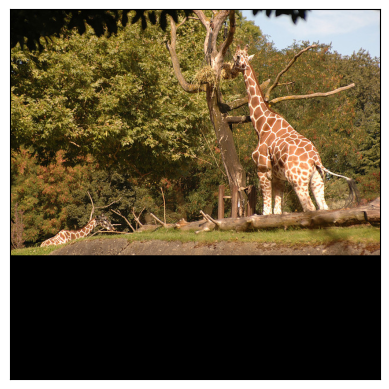

In [8]:
print(img)
print(img.image_id)
print(img.image_path)

print(">>>>")
print(img.captions())

print(">>>>")
print(img.qa())

show([img.image_tensor()])

#plt.imshow(  img.image_tensor().permute(1, 2, 0)  )


In [9]:
tokenizer  = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Add the Q and A token as special token
tokenizer.add_special_tokens(constants.QA_TOKEN_DICT)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


4

In [10]:
def annotate_qa(q, a):
    return constants.QUESTION_TOKEN + ' ' + q.lower() + ' ' + constants.ANSWER_TOKEN + ' ' + a.lower() + ' ' + constants.END_TOKEN
    
# flatten the imgae data into (image, caption, qa)
def collate_fn(batch):
    '''
    Padds batch of variable length
    '''
    results = []
    
    for idx, data in enumerate(batch):
        caption_list = data.captions()
        if caption_list is None:
            caption_list = [constants.EMPTY_TOKEN]
        
        qa_list = data.qa()
        if qa_list is None:
            qa_list = [(constants.EMPTY_TOKEN,constants.EMPTY_TOKEN)]
            
        for c in caption_list:
            for (q, a) in qa_list:
                results.append((data.image_id, data.image_tensor().to(device), c, annotate_qa(q,a)))
    return results

def collate_fn2(batch):
    result = {}
    
    result['image_ids'] = []
    result['images'] = []
    result['captions'] = []
    result['qa'] = []
    result['c2i'] = [] # index for images for a given caption. same len as 'caption'
    result['qa2i'] = [] # index of corresponding image for a given qa. same len as 'qa'
    target  = [] # the corresponding target for the qa.
    for idx, data in enumerate(batch):
        result['image_ids'].append(data.image_id)
        result['images'].append(data.image_tensor())
        caption_list = data.captions()
        if caption_list is not None:
            result['captions'] += caption_list
            for c in range(len(caption_list)):
                result['c2i'].append(idx)
        
        qa_list = data.qa()
        if qa_list is not None:
            result['qa'] += qa_list
            for c in range(len(qa_list)):
                result['qa2i'].append(idx)
#    target =         
    return result

In [11]:
from torch.utils.data import DataLoader
batch_size = 64
#fn = collate_fn
fn = collate_fn2
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=fn)
#val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True, collate_fn=fn)
#test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, collate_fn=fn)

In [12]:
x = next(iter(train_dataloader))

In [13]:
images = torch.arange(12).reshape(3, 4)
print(images)

b = torch.broadcast_to(images, (2, 3, 4))
print(b)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]])


In [14]:
print(images.shape)

torch.Size([3, 4])


In [15]:
model = VQANet(tokenizer).to(device)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
start_time = time.time()

for idx, x in enumerate(train_dataloader):
    print(">>>> Processing batch: ", idx)
    
    # Zero your gradients for every batch!
    optimizer.zero_grad()
    image_embedding, captions_embedding, output_logits = model(x, device)
    print(output_logits.shape)
    print("--- %s Per batch time ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))


>>>> Processing batch:  0
torch.Size([64, 3, 640, 640])
feature_map odict_keys(['0', '1', '2', '3', 'pool'])
projection torch.Size([64, 768])
image_embedding torch.Size([64, 768])
captions_embedding torch.Size([320, 768])
qa_tokens keys dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
embedding torch.Size([20, 253, 768])
image_embed_for_qa torch.Size([20, 253, 768])
qa_mask torch.Size([20, 20])
out_logits torch.Size([20, 253, 30526])
torch.Size([20, 253, 30526])
--- 6.507318735122681 Per batch time ---
>>>> Processing batch:  1
torch.Size([64, 3, 640, 640])
feature_map odict_keys(['0', '1', '2', '3', 'pool'])
projection torch.Size([64, 768])
image_embedding torch.Size([64, 768])
captions_embedding torch.Size([320, 768])
qa_tokens keys dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
embedding torch.Size([23, 201, 768])
image_embed_for_qa torch.Size([23, 201, 768])
qa_mask torch.Size([23, 23])
out_logits torch.Size([23, 201, 30526])
torch.Size([23, 201, 30526])
-

KeyboardInterrupt: 

In [11]:
print(output_logits.shape)

torch.Size([23, 225, 30526])


In [ ]:
qa_emb = model.text_encoder(qa_tokens)

In [ ]:
print(qa_emb.shape)

In [ ]:

mask = nn.Transformer.generate_square_subsequent_mask(qa_emb.shape[1]).to(device)
print(mask.shape)


In [ ]:
output_embedding = self.decoder(tgt = qa_embed, memory = image_embedding, tgt_mask=qa_mask )


In [ ]:
out = encoder(captions)

In [ ]:
print(out.pooler_output.shape)

In [ ]:
x = torch.tensor([[1, 2, 3], [4,5,6]])
torch.broadcast_to(x, (4, 2, 3))